## Data Cleaning

In [ ]:
import pandas as pd
import numpy as np

application = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_application_sampled.csv')
performance = pd.read_csv('/Users/will/Documents/GitHub/consumer-credit-risk/coursework2_performance_data_sampled.csv')

# merge the data from the two csvs
data_full = performance.merge(application, on='LOAN SEQUENCE NUMBER', how='left')

# change monthly reoprting period to datetime
data_full['MONTHLY REPORTING PERIOD'] = pd.to_datetime(data_full['MONTHLY REPORTING PERIOD'], format='%Y%m')

# if column value is RA then it is 0
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x == 'RA' else x)

# change to int
data_full['CURRENT LOAN DELINQUENCY STATUS'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].astype(int)
# change the column CURRENT LOAN DELINQUENCY STATUS
# slide 13 4 intro to analytics
# if value is less then 3 then it is 0 # else it is 1 # zero represents no default # one represents default
data_full['DEFAULT'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 0 if x < 3 else 1)

########### data cleaning ###########
# if zero balance code is 1 then remove the row
data_full = data_full[~(data_full['ZERO BALANCE CODE'] == 1)]

# remove the rows where CURRENT ACTUAL UPB is 0
data_full = data_full[~(data_full['CURRENT ACTUAL UPB'] == 0)]

data_full['CUMULATIVE MODIFICATION COST'].fillna(0, inplace=True)
data_full['STEP MODIFICATION FLAG'].fillna('Not modified', inplace=True)
data_full['PAYMENT DEFERRAL'].fillna('Not payment deferral', inplace=True)
data_full['DELINQUENT ACCRUED INTEREST'].fillna(0, inplace=True)
#data_full['DELINQUENCY DUE TO DISASTER'].fillna('N', inplace=True)
#data_full['BORROWER ASSISTANCE STATUS CODE'].fillna('N', inplace=True)
data_full['CURRENT MONTH MODIFICATION COST'].fillna(0, inplace=True)
#data_full['RELIEF REFINANCE INDICATOR'].fillna('N', inplace=True)
#data_full['SUPER CONFORMING FLAG'].fillna('N', inplace=True)
data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'].fillna('unknown', inplace=True)
# drop DEFECT SETTLEMENT DATE
data_full.drop(columns=['DEFECT SETTLEMENT DATE'], inplace=True)

# change METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION to category
data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'] = data_full['METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION'].astype('category')

# drop the columns with more than 90% missing values
data_full = data_full.loc[:, data_full.isnull().mean() <= 0.9]

# Replace specific missing values with 'N'
missing_value_map = {
    'CREDIT SCORE': [9999],
    'FIRST TIME HOMEBUYER FLAG': [9],
    'MI PERCENT': [999],
    'NUMBER OF UNITS': [99],
    'OCCUPANCY STATUS': [9],
    'ORIGINAL CLTV': [999],
    'ORIGINAL DTI RATIO': [999],
    'ORIGINAL LTV': [999],
    'CHANNEL': [9],
    'PROPERTY TYPE': [99],
    'LOAN PURPOSE': [9],
    'NUMBER OF BORROWERS': [99],
    'PROGRAM INDICATOR': [9],
    'PROPERTY VALUATION METHOD': [9],
    'MI CANCELLATION INDICATOR': [9, 7]
}

for column, values in missing_value_map.items():
    if column in data_full.columns:
        data_full[column] = data_full[column].replace(values, np.nan)

# replace 

# List of columns to convert to datetime
date_columns = [
    'MONTHLY REPORTING PERIOD', 
    'FIRST PAYMENT DATE', 
    'MATURITY DATE'
]

# Convert the specified columns to datetime
for column in date_columns:
    if column in data_full.columns:
        data_full[column] = pd.to_datetime(data_full[column], errors='coerce')

###### feature engineering ########

# add boolean for whether loan in delinquency or not 
data_full['DELINQUENCY'] = data_full['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x : 1 if x != 0 else 0)

# cum sum of the delinquency status
data_full['DEFAULT CUM SUM'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DEFAULT'].cumsum()

# last month current loan deliquency status
data_full['LAST MONTH DELINQUENCY STATUS'] = data_full.groupby('LOAN SEQUENCE NUMBER')['CURRENT LOAN DELINQUENCY STATUS'].shift(1).fillna(0)

# rolling 12 months time in deliquency
data_full['MONTHS IN DELINQUENCY PAST 12'] = data_full.groupby('LOAN SEQUENCE NUMBER')['DELINQUENCY'].rolling(12, min_periods=1).sum().reset_index(drop=True)

# make a function that takes in a pd.series of zeroes and ones and then returns a new series with every 12 before the ones being ones as well
def default_next_12(default_vector):
     
    if np.where(default_vector==1)[0].size==0:
        return default_vector
     
    first_default = np.where(default_vector==1)[0][0]
    defualt_next_12_vector = np.zeros(len(default_vector))
    defualt_next_12_vector[max(0,first_default-12):] = 1

    return(defualt_next_12_vector)

default_next_12_col = []

# group the data by LOAN SEQUENCE NUMBER
for _, group in data_full.groupby('LOAN SEQUENCE NUMBER'):
    default_next_12_series = default_next_12(group['DEFAULT'])

    default_next_12_col.extend(default_next_12_series)

data_full['DEFAULT_NEXT_12'] = [x == 1 for x in default_next_12_col]

# remove rows where the cumsum != 0
data_full = data_full[data_full['DEFAULT CUM SUM'] == 0]

# make training data
data_full_train = data_full[data_full['MONTHLY REPORTING PERIOD'] < '2022-06-01']

# make out of time data
data_full_oot = data_full[data_full['MONTHLY REPORTING PERIOD'] == '2023-06-01']


In [143]:
from sklearn.model_selection import train_test_split

# Split the data into features and target
X = data_full_train.drop(columns=['DEFAULT_NEXT_12', 'MONTHLY REPORTING PERIOD', 'LOAN SEQUENCE NUMBER', 
                                  'DEFAULT', 'DEFAULT CUM SUM', 'MATURITY DATE', 'SELLER NAME', 'FIRST PAYMENT DATE', 'SERVICER NAME',
                                  'METROPOLITAN STATISTICAL AREA (MSA) OR METROPOLITAN DIVISION', 'DELINQUENCY', 'NUMBER OF UNITS'])
y = data_full_train['DEFAULT_NEXT_12']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Weight of Evidence

In [144]:
import warnings
import numpy as np
import pandas as pd
import scorecardpy as sc
from string import ascii_letters
import sys

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings("ignore")

# combine X and y to make a new dataframe
X_train = pd.concat([X_train, y_train], axis=1)

# combine one column in X_train with y_train

#woe_test = pd.concat([X_train['CREDIT SCORE'], y_train], axis=1)

# replace str in X_train['CREDIT SCORE'] with na
#woe_test['CREDIT SCORE'] = woe_test['CREDIT SCORE'].replace('N', np.nan)

bins = sc.woebin(X_train, y='DEFAULT_NEXT_12',
                 min_perc_fine_bin=0.02, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.02, # Minimum information value
                 max_num_bin=8, # Maximum number of bins
                 method='tree'
                 )


[INFO] creating woe binning ...
Binning on 497171 rows and 33 columns in 00:01:17


In [ ]:
sc.woebin_plot(bins)
plt.show()

bins

In [142]:
display(bins)

{'NUMBER OF UNITS':           variable         bin   count  count_distr    good   bad   badprob  \
 0  NUMBER OF UNITS  [-inf,inf)  497171          1.0  491761  5410  0.010882   
 
    woe  bin_iv  total_iv breaks  is_special_values  
 0  0.0     0.0       0.0    inf              False  ,
 'LOAN AGE':    variable          bin   count  count_distr    good   bad   badprob  \
 0  LOAN AGE  [-inf,18.0)  298909     0.601220  296682  2227  0.007450   
 1  LOAN AGE  [18.0,22.0)   31106     0.062566   30768   338  0.010866   
 2  LOAN AGE  [22.0,30.0)   28092     0.056504   27627   465  0.016553   
 3  LOAN AGE  [30.0,48.0)   39549     0.079548   38649   900  0.022757   
 4  LOAN AGE  [48.0,76.0)   74229     0.149303   73175  1054  0.014199   
 5  LOAN AGE   [76.0,inf)   25286     0.050860   24860   426  0.016847   
 
         woe        bin_iv  total_iv breaks  is_special_values  
 0 -0.382262  7.326435e-02  0.176632   18.0              False  
 1 -0.001441  1.297966e-07  0.176632   22.0     

-------- 1/32 LOAN AGE --------
>>> dt[LOAN AGE].describe(): 
count    497171.000000
mean         23.726786
std          24.149248
min           0.000000
25%           6.000000
50%          13.000000
75%          36.000000
max         100.000000
Name: LOAN AGE, dtype: float64 



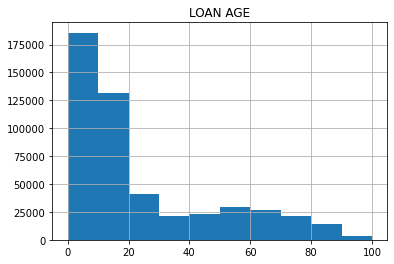

>>> Current breaks:
18.0,22.0,30.0,48.0,76.0 



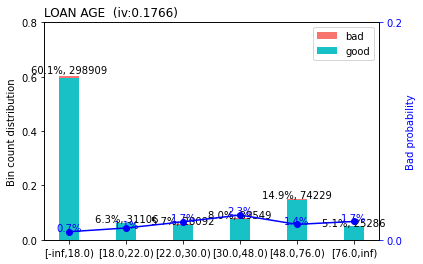

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 22.0, 48.0, 18.0 



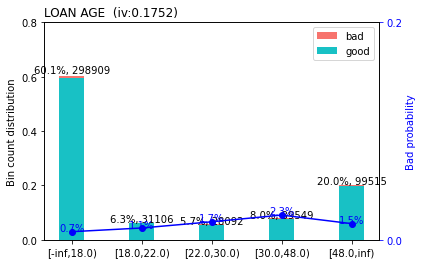

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
Input could not be converted to digit.
Input could not be converted to digit.
Input could not be converted to digit.
Input could not be converted to digit.
Input could not be converted to digit.
[INFO] creating woe binning ...
>>> Current breaks:
22.0, 48.0, 18.0, 76.0 



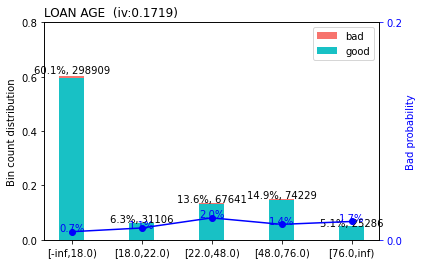

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
Input could not be converted to digit.
[INFO] creating woe binning ...
>>> Current breaks:
48.0, 22.0, 9.0, 18.0 



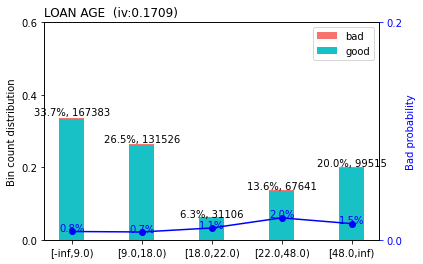

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 48.0, 55.0 



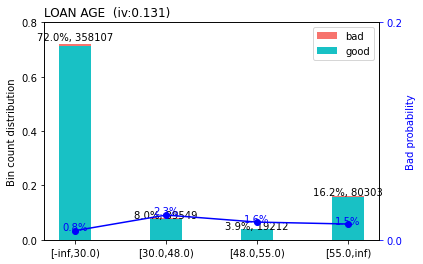

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 76.0, 9.0, 18.0, 22.0, 48.0 



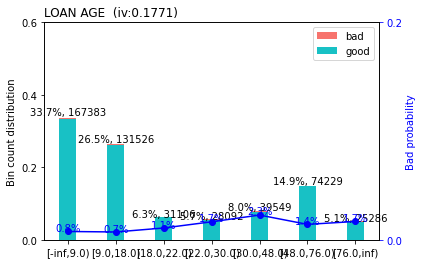

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 9.0, 18.0, 22.0, 48.0 



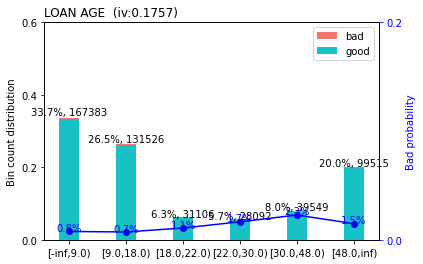

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
Input could not be converted to digit.
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 12.0, 76.0, 6.0, 18.0, 22.0, 48.0 



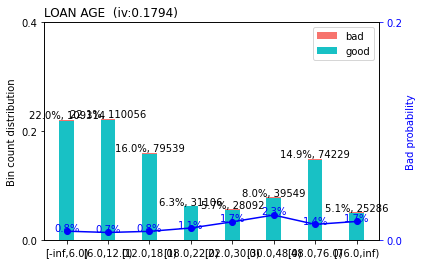

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
Input could not be converted to digit.
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 12.0, 6.0, 18.0, 22.0, 48.0 



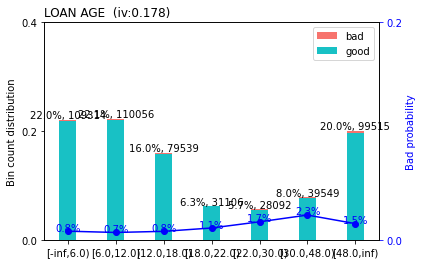

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 76.0, 6.0, 18.0, 22.0, 48.0 



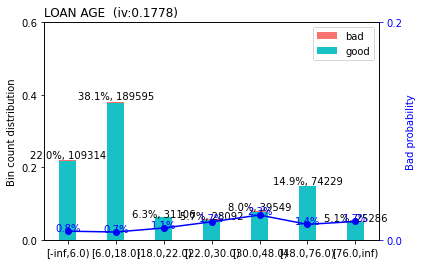

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
Input could not be converted to digit.
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 9.0, 18.0, 22.0, 48.0 



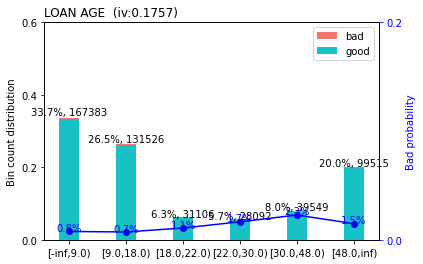

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
[INFO] creating woe binning ...
>>> Current breaks:
30.0, 22.0, 9.0, 48.0 



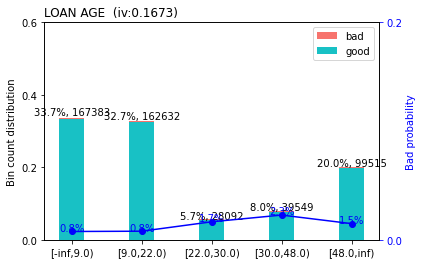

>>> Adjust breaks for (1/32) LOAN AGE?
1: next 
2: yes 
3: back
-------- 2/32 NUMBER OF BORROWERS --------
>>> dt[NUMBER OF BORROWERS].describe(): 
count    497171.000000
mean          1.473740
std           0.516949
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: NUMBER OF BORROWERS, dtype: float64 

>>> dt[NUMBER OF BORROWERS].value_counts(): 
1    265652
2    227953
3      3121
4       445
Name: NUMBER OF BORROWERS, dtype: int64 

>>> Current breaks:
2.0 



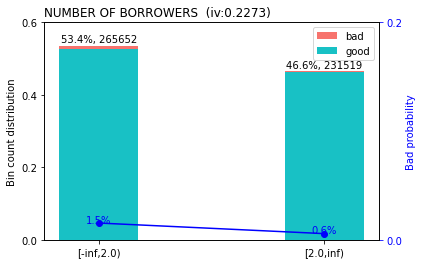

>>> Adjust breaks for (2/32) NUMBER OF BORROWERS?
1: next 
2: yes 
3: back
[INFO] creating woe binning ...
>>> Current breaks:
5.0, 2.0, 4.0, 3.0 

>>> Adjust breaks for (2/32) NUMBER OF BORROWERS?
1: next 
2: yes 
3: back
[INFO] creating woe binning ...
>>> Current breaks:
5.0, 2.0, 4.0, 3.0 

>>> Adjust breaks for (2/32) NUMBER OF BORROWERS?
1: next 
2: yes 
3: back
-------- 3/32 OCCUPANCY STATUS --------
>>> dt[OCCUPANCY STATUS].describe(): 
count     497171
unique         3
top            P
freq      440592
Name: OCCUPANCY STATUS, dtype: object 

>>> dt[OCCUPANCY STATUS].value_counts(): 
P    440592
I     38549
S     18030
Name: OCCUPANCY STATUS, dtype: int64 

>>> Current breaks:
'S%,%I','P' 



posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


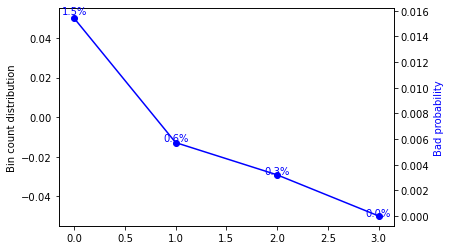

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


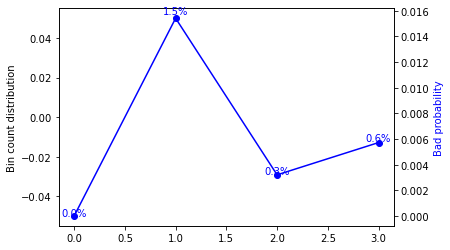

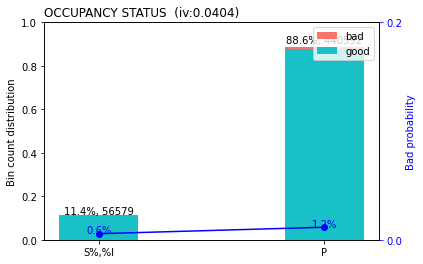

>>> Adjust breaks for (3/32) OCCUPANCY STATUS?
1: next 
2: yes 
3: back
-------- 4/32 PROPERTY STATE --------
>>> dt[PROPERTY STATE].describe(): 
count     497171
unique         4
top           CA
freq      200238
Name: PROPERTY STATE, dtype: object 

>>> dt[PROPERTY STATE].value_counts(): 
CA    200238
TX    115374
FL    106481
IL     75078
Name: PROPERTY STATE, dtype: int64 

>>> Current breaks:
'CA','FL','TX','IL' 



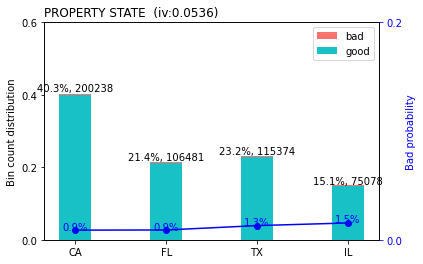

>>> Adjust breaks for (4/32) PROPERTY STATE?
1: next 
2: yes 
3: back
-------- 5/32 CURRENT INTEREST RATE --------
>>> dt[CURRENT INTEREST RATE].describe(): 
count    497171.000000
mean          3.388941
std           0.738206
min           1.750000
25%           2.875000
50%           3.250000
75%           3.875000
max           6.750000
Name: CURRENT INTEREST RATE, dtype: float64 



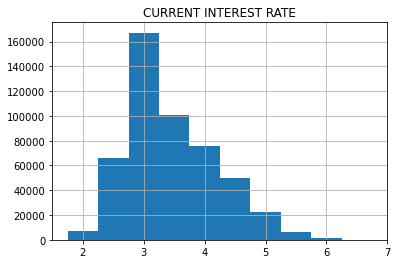

>>> Current breaks:
2.700000000000001,3.3000000000000016,3.5000000000000018,4.200000000000003,4.500000000000003 



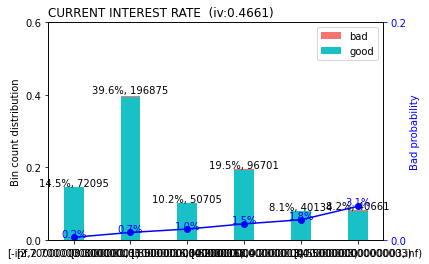

>>> Adjust breaks for (5/32) CURRENT INTEREST RATE?
1: next 
2: yes 
3: back
-------- 6/32 STEP MODIFICATION FLAG --------
>>> dt[STEP MODIFICATION FLAG].describe(): 
count           497171
unique               2
top       Not modified
freq            497170
Name: STEP MODIFICATION FLAG, dtype: object 

>>> dt[STEP MODIFICATION FLAG].value_counts(): 
Not modified    497170
N                    1
Name: STEP MODIFICATION FLAG, dtype: int64 

>>> Current breaks:
'N%,%Not modified' 



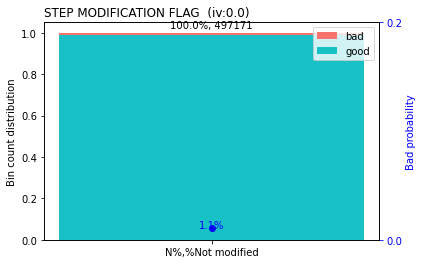

>>> Adjust breaks for (6/32) STEP MODIFICATION FLAG?
1: next 
2: yes 
3: back
-------- 7/32 LOAN PURPOSE --------
>>> dt[LOAN PURPOSE].describe(): 
count     497171
unique         3
top            N
freq      211792
Name: LOAN PURPOSE, dtype: object 

>>> dt[LOAN PURPOSE].value_counts(): 
N    211792
P    175990
C    109389
Name: LOAN PURPOSE, dtype: int64 

>>> Current breaks:
'N','C','P' 



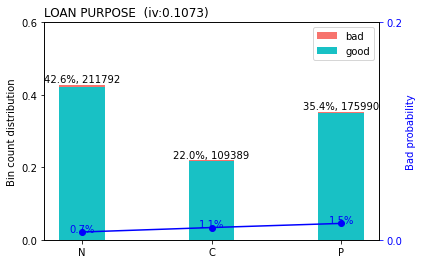

>>> Adjust breaks for (7/32) LOAN PURPOSE?
1: next 
2: yes 
3: back
-------- 8/32 CHANNEL --------
>>> dt[CHANNEL].describe(): 
count     497171
unique         3
top            R
freq      265640
Name: CHANNEL, dtype: object 

>>> dt[CHANNEL].value_counts(): 
R    265640
C    151976
B     79555
Name: CHANNEL, dtype: int64 

>>> Current breaks:
'B','C','R' 



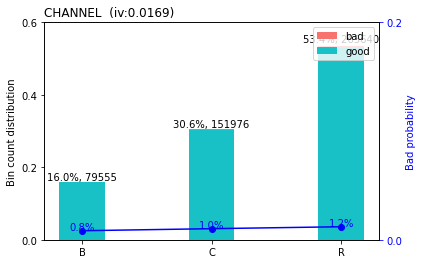

>>> Adjust breaks for (8/32) CHANNEL?
1: next 
2: yes 
3: back
-------- 9/32 ORIGINAL UPB --------
>>> dt[ORIGINAL UPB].describe(): 
count    4.971710e+05
mean     2.847896e+05
std      1.522772e+05
min      1.300000e+04
25%      1.690000e+05
50%      2.560000e+05
75%      3.720000e+05
max      1.344000e+06
Name: ORIGINAL UPB, dtype: float64 



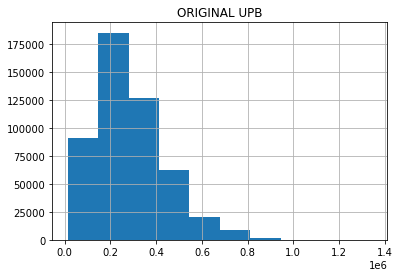

>>> Current breaks:
120000.0,160000.0,340000.0,520000.0 



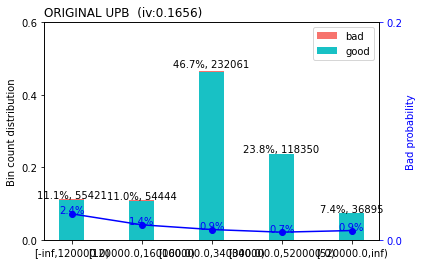

>>> Adjust breaks for (9/32) ORIGINAL UPB?
1: next 
2: yes 
3: back
[INFO] creating woe binning ...
>>> Current breaks:
340000.0, 160000.0, 120000.0 



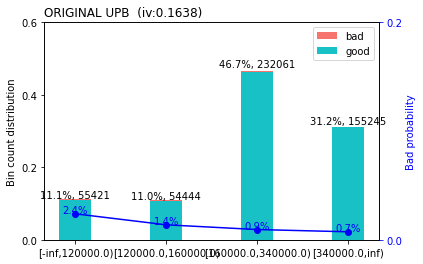

>>> Adjust breaks for (9/32) ORIGINAL UPB?
1: next 
2: yes 
3: back
-------- 10/32 PROPERTY VALUATION METHOD --------
>>> dt[PROPERTY VALUATION METHOD].describe(): 
count    413422.000000
mean          1.679543
std           0.521198
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: PROPERTY VALUATION METHOD, dtype: float64 

>>> dt[PROPERTY VALUATION METHOD].value_counts(): 
2.0    258662
1.0    143622
3.0     11138
Name: PROPERTY VALUATION METHOD, dtype: int64 

>>> Current breaks:
2.0 



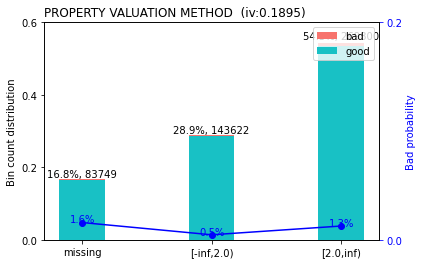

>>> Adjust breaks for (10/32) PROPERTY VALUATION METHOD?
1: next 
2: yes 
3: back
-------- 11/32 LAST MONTH DELINQUENCY STATUS --------
>>> dt[LAST MONTH DELINQUENCY STATUS].describe(): 
count    497171.000000
mean          0.007301
std           0.093102
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: LAST MONTH DELINQUENCY STATUS, dtype: float64 

>>> dt[LAST MONTH DELINQUENCY STATUS].value_counts(): 
0.0    493894
1.0      2924
2.0       353
Name: LAST MONTH DELINQUENCY STATUS, dtype: int64 

>>> Current breaks:


KeyError: 'LAST MONTH DELINQUENCY STATUS'

In [145]:
breaks_adj = sc.woebin_adj(X_train, "DEFAULT_NEXT_12", bins, adj_all_var=True)